Burgers' Equation:
\begin{split}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = D \frac{\partial^2 u}{\partial x^2}
\end{split}

Discretization, using centered differences and implicit timestep:
\begin{split}
\frac{u_i - u_i^{old}}{\Delta t} + u_i \frac{u_{i+1} - u_{i-1}}{2 \Delta x} = D \frac{u_{i+1} - 2u_i + u_{i-1}}{\Delta x^2}
\end{split}

Consider the steady case:
\begin{split}
u_i \frac{u_{i+1} - u_{i-1}}{2 \Delta x} = D \frac{u_{i+1} - 2u_i + u_{i-1}}{\Delta x^2}
\end{split}

This must be solved iteratively. To linearize the self-advection term, assume the velocity being advected in the self-advection term is known from the last iteration. Define $\phi = u^{last}$
\begin{split}
\phi_i \frac{u_{i+1} - u_{i-1}}{2 \Delta x} = D \frac{u_{i+1} - 2u_i + u_{i-1}}{\Delta x^2}
\end{split}

Group terms to form system matrix:
\begin{split}
u_{i+1} \left( \frac{\phi_i}{2\Delta x} - \frac{D}{\Delta x^2} \right) + u_i \left( \frac{2D}{\Delta x^2} \right) + u_{i-1} \left( \frac{-\phi_i}{2\Delta x} - \frac{D}{\Delta x^2} \right) = 0
\end{split}

We can define our linearized system as follows, where the coefficient matrix is a function of the previous iteration:
\begin{split}
A(x^{last}) x = b
\end{split}

To solve iteratively, we minimize the following:
\begin{split}
f(x) = || A x - b ||_2^2
\end{split}

You could use whatever method to do this. Below, noticing that $f(x)$ is quadratic:
\begin{split}
f(x) = x^T A^T A x - 2 b^T A x - b^T b \\
\nabla f(x) = 2 A^T (A x - b) \\
\nabla^2 f(x) = 2 A^T A
\end{split}

First, we will use a Newton update:
\begin{split}
x^{next} = x - \frac{\nabla f(x)}{\nabla^2 f(x)} = x - \left(\nabla^2 f(x) \right)^{-1} \nabla f(x) 
\end{split}

In [215]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import scipy

In [216]:
L = 1
N = 51
dx = L / (N - 1)
print("dx:", dx)
D = 0.02
x_0 = 0.0
x_L = 1.0

dx: 0.02


In [217]:
grid = np.linspace(0, L, N)
grid

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])

In [218]:
def system(phi):
    A = np.zeros((N, N))
    b = np.zeros((N))

    for rdx in range(1, N - 1):
        A[rdx, rdx - 1] = - phi[rdx] / (2 * dx) - D / (dx**2)
        A[rdx, rdx] = 2 * D / (dx**2)
        A[rdx, rdx + 1] = phi[rdx] / (2 * dx) - D / (dx**2)
    
    A[0, 0] = 1
    A[N - 1, N - 1] = 1
    b[0] = x_0
    b[N - 1] = x_L

    return A, b

In [219]:
A, b = system(np.ones((N)))
#A, b

In [220]:
xvec = np.ones((N))

# (quadratic) obj: min ||Ax-b||_2^2
f = lambda A, x, b: x.T @ A.T @ A @ x - 2 * b.T @ A @ x + b @ b

# gradient:
g = lambda A, x, b: 2 * A.T @ (A @ x - b)

# hessian:
h = lambda A, x, b: 2 * A.T @ A

f(A, xvec, b), g(A, xvec, b), h(A, xvec, b).shape

(np.float64(1.0),
 array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 (51, 51))

Solution converged to tolerance at iteration 37


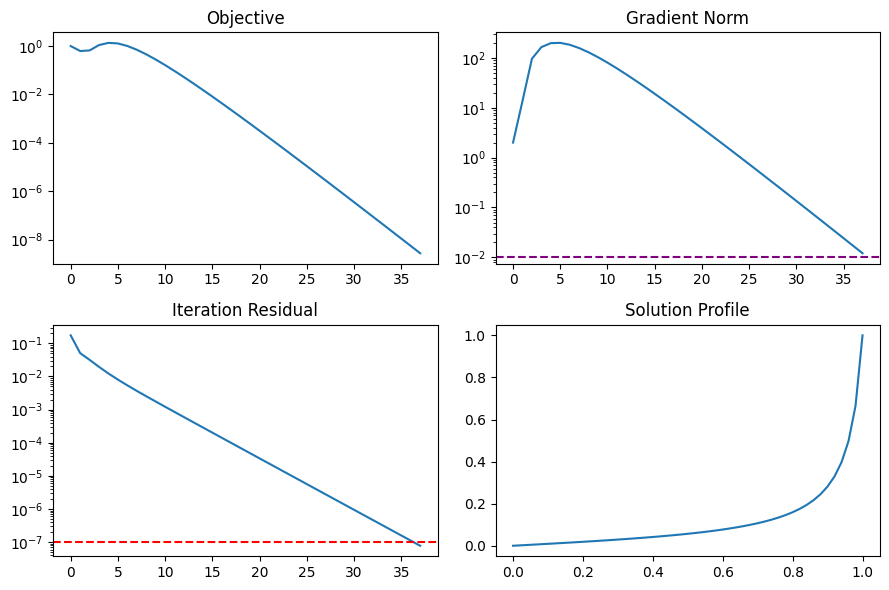

In [233]:
# solve the system using gradient descent or newton method
# newton method works better here since inverting the system matrix for a 1d case is not that intensive
# it also converges much better than gradient descent
# for a 2d case with a quadratically larger matrix, try other methods
update_mode = "hessian"

# init guess solution
xvec = np.random.rand(N)
xvec = np.zeros(N)

# track: obj, grad
obj_list = []
grad_list = []
hessian_list = []
# track convergence
err_list = []
# track solution history
xvec_list = []

tol_itr = 1e-7
tol_grad = 1e-2

for itr in range(int(1e3)):
    # store solution history
    xvec_list.append(xvec)
    # build linear system
    A, b = system(xvec)
    # calculate and store obj grad hessian
    obj = f(A, xvec, b)
    obj_list.append(obj)
    grad = g(A, xvec, b)
    grad_list.append(grad)
    hessian = h(A, xvec, b)
    hessian_list.append(hessian)
    # calculate update
    first_order_update = - 0.003 * grad
    second_order_update = - 0.3 * np.linalg.inv(hessian) @ grad
    # apply update
    if update_mode == "gradient":
        xnew = xvec + first_order_update
    elif update_mode == "hessian":
        xnew = xvec + second_order_update
    else:
        print("INVALID UPDATE SELECTED")
        break
    rmse = np.sqrt(np.sum(np.mean((xnew - xvec)**2)))
    gradnorm = np.linalg.norm(grad)
    # calculate error and check convergence
    err_list.append(rmse)
    if rmse <= tol_itr or gradnorm <= tol_grad:
        print("Solution converged to tolerance at iteration", itr)
        break
    # if not converged, prepare for next iteration
    xvec = xnew

fig, axes = plt.subplots(2, 2, figsize=(9,6))

axes[0, 0].semilogy(obj_list)
axes[0, 0].set_title("Objective")

axes[0, 1].semilogy([np.linalg.norm(item) for item in grad_list])
axes[0, 1].axhline(tol_grad, color="purple", linestyle="--")
axes[0, 1].set_title("Gradient Norm")

# axes[0, 1].semilogy([np.linalg.norm(gitem @ np.linalg.inv(hitem)) for gitem, hitem in zip(grad_list, hessian_list)])
# axes[0, 1].set_title(r"$||\nabla f(x) / (\nabla^2 f(x))^{-1}||$")

axes[1, 0].semilogy(err_list)
axes[1, 0].axhline(tol_itr, color="red", linestyle="--")
axes[1, 0].set_title("Iteration Residual")

axes[1, 1].plot(grid, xvec)
axes[1, 1].set_title("Solution Profile")

plt.tight_layout()

Using Newton method is fine for this simple 1D case, but can be impractical for larger 2D systems.

However, these systems can often be ill-conditioned. As can be seen by trying gradient descent above, the convergence is very unstable.

In [222]:
# thats a very high condition number. 
# if we want to use gradient descent we will need to precondition the system.
# note that these hessian and A matrices are from the last iterations
np.linalg.cond(hessian), np.linalg.cond(A.T @ A), np.linalg.cond(A)

(np.float64(3844123.9776139674),
 np.float64(3844123.9776139674),
 np.float64(1960.6437660875947))

We will use the sparse approximate inverse preconditioner, as described [here](https://tbetcke.github.io/hpc_lecture_notes/it_solvers4.html).

Read more about the selection of a preconditioning matrix on [Wikipedia](https://en.wikipedia.org/wiki/Preconditioner).

With a preconditioning matrix $M = P^{-1}$, the system becomes:
\begin{split}
P^{-1} A x = P^{-1} b
\end{split}

and we can plug $MA$ and $Mb$ directly into the gradient descent algorithm.

In [223]:
def SPAI(A, m):
    """Perform m step of the SPAI iteration."""
    from scipy.sparse import identity
    from scipy.sparse import diags
    from scipy.sparse.linalg import onenormest
    
    n = A.shape[0]
    
    ident = identity(n, format='csr')
    alpha = 2 / onenormest(A @ A.T)
    M = alpha * A
        
    for index in range(m):
        C = A @ M
        G = ident - C
        AG = A @ G
        trace = (G.T @ AG).diagonal().sum()
        alpha = trace / np.linalg.norm(AG.data)**2
        M = M + alpha * G
        
    return np.array(M)

Solution converged to tolerance at iteration 947


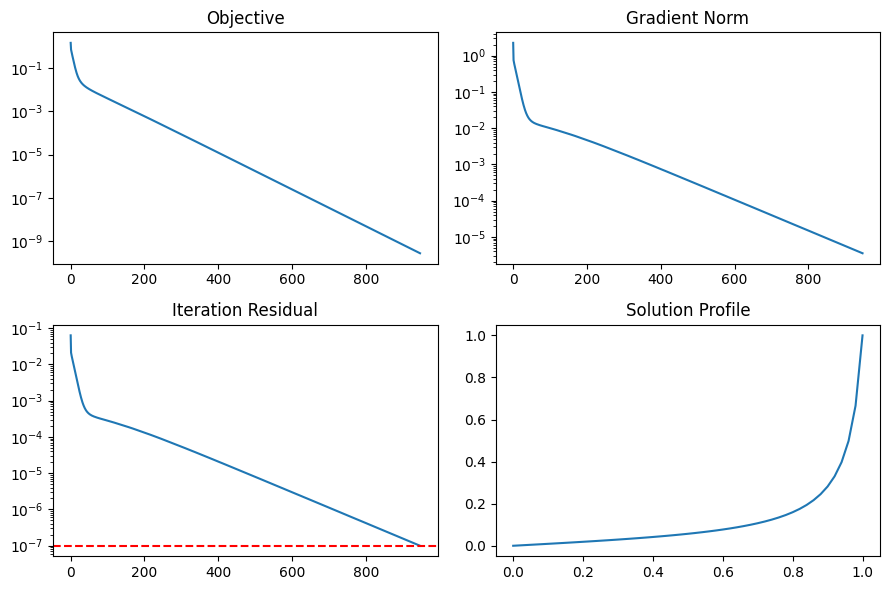

In [230]:
# init guess solution
xvec = np.zeros(N)

# track: obj, grad
obj_list = []
grad_list = []
hessian_list = []
# track convergence
err_list = []
# track solution history
xvec_list = []

tol_itr = 1e-7

for itr in range(int(1e4)):
    # store solution history
    xvec_list.append(xvec)
    # build linear system
    A, b = system(xvec)
    M = SPAI(A, 100)
    MA = M @ A
    Mb = M @ b
    # calculate and store obj grad hessian
    obj = f(MA, xvec, Mb)
    obj_list.append(obj)
    grad = g(MA, xvec, Mb)
    grad_list.append(grad)
    hessian = h(MA, xvec, Mb)
    hessian_list.append(hessian)
    # calculate update
    first_order_update = - 0.2 * grad
    # apply update
    xnew = xvec + first_order_update
    rmse = np.sqrt(np.sum(np.mean((xnew - xvec)**2)))
    # calculate error and check convergence
    err_list.append(rmse)
    if rmse <= tol_itr:
        print("Solution converged to tolerance at iteration", itr)
        break
    # if not converged, prepare for next iteration
    xvec = xnew

fig, axes = plt.subplots(2, 2, figsize=(9,6))

axes[0, 0].semilogy(obj_list)
axes[0, 0].set_title("Objective")

axes[0, 1].semilogy([np.linalg.norm(item) for item in grad_list])
axes[0, 1].set_title("Gradient Norm")

axes[1, 0].semilogy(err_list)
axes[1, 0].axhline(tol_itr, color="red", linestyle="--")
axes[1, 0].set_title("Iteration Residual")

axes[1, 1].plot(grid, xvec)
axes[1, 1].set_title("Solution Profile")

plt.tight_layout()